<a href="https://colab.research.google.com/github/Piyush1803/EDA-RollerCoaster-Analysis/blob/main/SuperStore_Sales_forecast_SQL_%2B_Analytics_Week_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

file_path = '/content/Sample_Superstore_Cleaned_UTF8.csv'
df = pd.read_csv(file_path)

print("Column Names:")
print(df.columns)

Column Names:
Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')


SQL Queries for Question 1


-- “What does the daily/weekly sales trend look like, and how is revenue evolving over time?”

-- Example 1 — Running Total of Revenue (Time Trend)

SELECT
    Order_Date,
    SUM(Sales) AS daily_sales,
    SUM(SUM(Sales)) OVER (
        ORDER BY Order_Date
    ) AS running_total_sales
FROM orders
GROUP BY Order_Date
ORDER BY Order_Date;


-- Example 2 — Weekly Revenue + Rank

SELECT
    YEAR(Order_Date) AS year,
    WEEK(Order_Date) AS week_num,
    SUM(Sales) AS weekly_sales,
    RANK() OVER (
        ORDER BY SUM(Sales) DESC
    ) AS week_sales_rank
FROM orders
GROUP BY year, week_num;



-- 2️⃣ CTE (WITH) QUERIES (2 EXAMPLES)
-- Example 1 — Clean CTE for Monthly Sales

WITH monthly_sales AS (
    SELECT
        DATE_FORMAT(Order_Date, '%Y-%m') AS year_month,
        SUM(Sales) AS total_sales
    FROM orders
    GROUP BY year_month
)
SELECT *
FROM monthly_sales
ORDER BY year_month;

-- Example 2 — CTE for Sales Change (Month-over-Month Growth)

WITH ms AS (
    SELECT
        DATE_FORMAT(Order_Date, '%Y-%m') AS ym,
        SUM(Sales) AS sales
    FROM orders
    GROUP BY ym
)
SELECT
    ym,
    sales,
    sales - LAG(sales, 1) OVER (ORDER BY ym) AS mom_growth
FROM ms
ORDER BY ym;

-- 3️⃣ PERFORMANCE (EXPLAIN + INDEXES) — 2 EXAMPLES
-- These are to check performance and understand indexing.
-- Example 1 — EXPLAIN a Time-Series Query


EXPLAIN ANALYZE
SELECT
    Order_Date,
    SUM(Sales)
FROM orders
GROUP BY Order_Date;

-- Example 2 — Add Index to Improve Date Filtering


CREATE INDEX idx_orders_order_date ON orders (Order_Date);
-- After creating an index:

EXPLAIN ANALYZE
SELECT *
FROM orders
WHERE Order_Date >= '2017-01-01';

⭐ QUESTION 2

“Which customer segments and regions contribute the most to sales and profit?”


1️⃣ WINDOW FUNCTION QUERIES (2 EXAMPLES)

Example 1 — Rank Regions by Revenue

SELECT
    Region,
    SUM(Sales) AS total_sales,
    RANK() OVER (ORDER BY SUM(Sales) DESC) AS region_rank
FROM orders
GROUP BY Region;


Example 2 — Segment Running Profit

SELECT
    Segment,
    SUM(Profit) AS total_profit,
    SUM(SUM(Profit)) OVER (
        ORDER BY SUM(Profit) DESC
    ) AS running_profit
FROM orders
GROUP BY Segment
ORDER BY total_profit DESC;


2️⃣ CTE QUERIES (2 EXAMPLES)

Example 1 — CTE for Segment Stats

WITH segment_stats AS (
    SELECT
        Segment,
        SUM(Sales) AS total_sales,
        SUM(Profit) AS total_profit
    FROM orders
    GROUP BY Segment
)

SELECT * FROM segment_stats
ORDER BY total_sales DESC;


Example 2 — Region Profitability CTE

WITH region_profit AS (
    SELECT
        Region,
        AVG(Profit) AS avg_profit,
        SUM(Profit) AS total_profit
    FROM orders
    GROUP BY Region
)
SELECT * FROM region_profit
ORDER BY avg_profit DESC;


3️⃣ PERFORMANCE EXAMPLES

Example 1 — EXPLAIN region query

EXPLAIN ANALYZE
SELECT Region, SUM(Sales)
FROM orders
GROUP BY Region;


Example 2 — Index Region column


CREATE INDEX idx_orders_region ON orders (Region);

⭐ QUESTION 3
“Is there a significant difference in profit between two regions (East vs West)?”
This will be used for your t-test in Colab.

1️⃣ WINDOW FUNCTION QUERIES (2 EXAMPLES)

Example 1 — Profit per Order + Rank

SELECT
    Region,
    Profit,
    RANK() OVER (PARTITION BY Region ORDER BY Profit DESC) AS profit_rank
FROM orders;

Example 2 — Rolling Average Profit (per region)


SELECT
    Region,
    Order_Date,
    AVG(Profit) OVER (
        PARTITION BY Region
        ORDER BY Order_Date
        ROWS BETWEEN 7 PRECEDING AND CURRENT ROW
    ) AS rolling_7day_profit
FROM orders
ORDER BY Order_Date;


2️⃣ CTE QUERIES (2 EXAMPLES)


Example 1 — Export East vs West Data


WITH ew AS (
    SELECT Region, Profit
    FROM orders
    WHERE Region IN ('East', 'West')
)
SELECT * FROM ew;


Example 2 — Profit Distribution per Region


WITH rp AS (
    SELECT Region, Profit
    FROM orders
)
SELECT
    Region,
    AVG(Profit) AS avg_profit,
    STDDEV(Profit) AS std_profit
FROM rp
GROUP BY Region;


3️⃣ PERFORMANCE EXAMPLES

Example 1 — EXPLAIN East/West

EXPLAIN ANALYZE

SELECT Region, Profit
FROM orders
WHERE Region IN ('East', 'West');


Example 2 — Index Region (if not done earlier)


CREATE INDEX idx_orders_region_profit ON orders (Region, Profit);

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(style="whitegrid")


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving daily_sales.csv to daily_sales.csv
Saving east_west_profit.csv to east_west_profit.csv
Saving region_stats.csv to region_stats.csv


In [ ]:
daily_sales = pd.read_csv('daily_sales.csv')
region_stats = pd.read_csv('region_stats.csv')
east_west_profit = pd.read_csv('east_west_profit.csv')

In [ ]:
daily_sales.head(), region_stats.head(), east_west_profit.head()

(  Order_Date  daily_sales
 0     1/1/18     1419.184
 1    1/10/15       54.830
 2    1/10/16     1018.104
 3    1/10/17      174.750
 4    1/11/15        9.940,
     Region  total_sales  total_profit
 0    South  388983.5850    46035.6890
 1     West  713471.3445   106021.1495
 2  Central  497800.8728    40128.9030
 3     East  663264.6840    88427.0344,
   Region   Profit
 0   West   6.8714
 1   West  14.1694
 2   West   1.9656
 3   West  90.7152
 4   West   5.7825)

In [ ]:
daily_sales['Order_Date'] = pd.to_datetime(daily_sales['Order_Date'])
daily_sales.describe()

/tmp/ipython-input-3556285513.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  daily_sales['Order_Date'] = pd.to_datetime(daily_sales['Order_Date'])


,Order_Date,daily_sales
count,1000,1000.000000
mean,2017-01-09 11:28:19.200000256,1776.090934
min,2015-01-04 00:00:00,2.025000
25%,2016-01-08 06:00:00,333.266500
50%,2017-01-24 12:00:00,1022.270000
75%,2018-01-15 06:00:00,2251.704750
max,2018-12-30 00:00:00,28106.716000
std,NaN,2261.240407


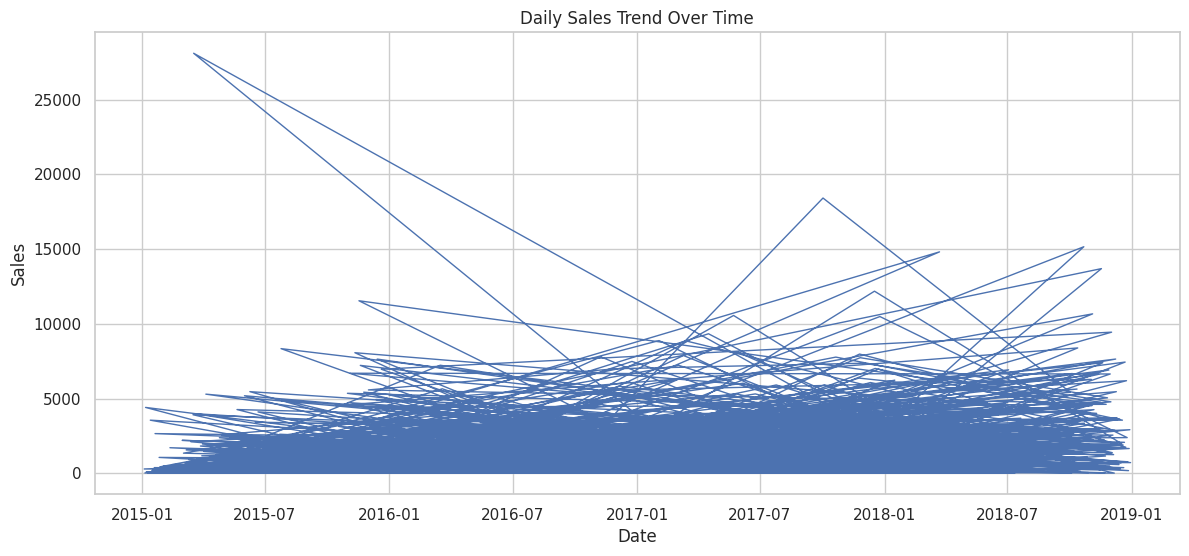

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(daily_sales['Order_Date'], daily_sales['daily_sales'], linewidth=1)
plt.title("Daily Sales Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

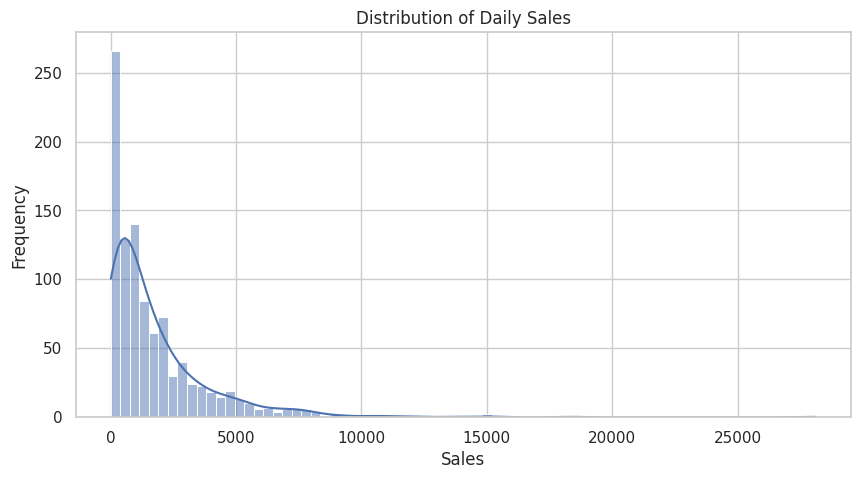

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(daily_sales['daily_sales'], kde=True)
plt.title("Distribution of Daily Sales")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

In [ ]:
region_stats_sorted = region_stats.sort_values(by='total_sales', ascending=False)
region_stats_sorted

,Region,total_sales,total_profit
1,West,713471.3445,106021.1495
3,East,663264.6840,88427.0344
2,Central,497800.8728,40128.9030
0,South,388983.5850,46035.6890


/tmp/ipython-input-1644564170.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=region_stats_sorted, x='Region', y='total_sales', palette='Blues_d')


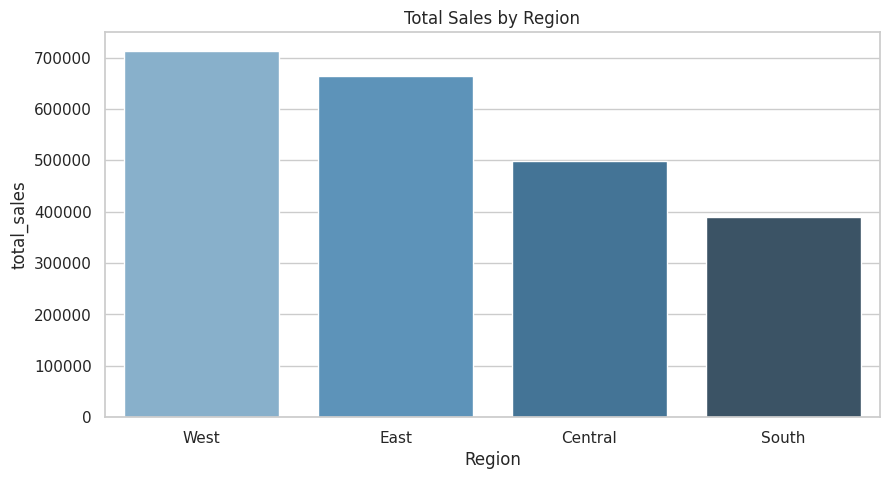

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(data=region_stats_sorted, x='Region', y='total_sales', palette='Blues_d')
plt.title("Total Sales by Region")
plt.show()


/tmp/ipython-input-443242385.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=region_stats_sorted, x='Region', y='total_profit', palette='Greens_d')


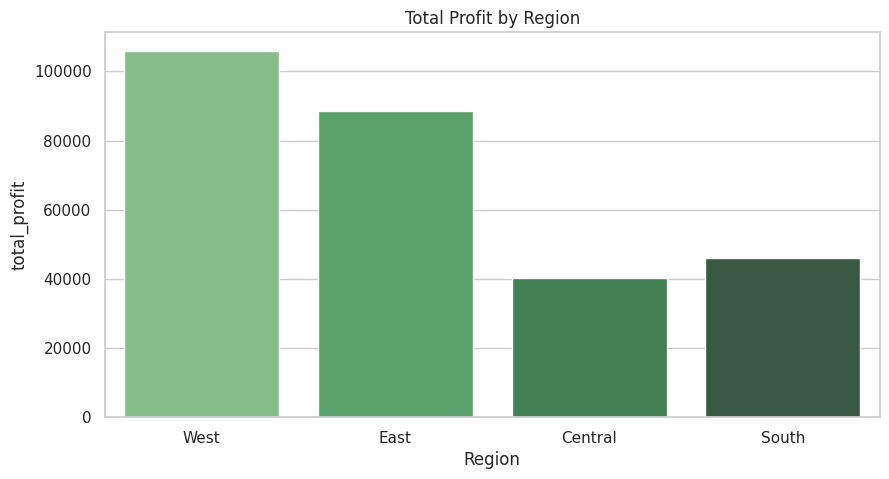

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(data=region_stats_sorted, x='Region', y='total_profit', palette='Greens_d')
plt.title("Total Profit by Region")
plt.show()


In [ ]:
east = east_west_profit[east_west_profit['Region'] == 'East']['Profit']
west = east_west_profit[east_west_profit['Region'] == 'West']['Profit']


In [ ]:
len(east), len(west)

(507, 493)

/tmp/ipython-input-3848941473.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(east_trim, shade=True, label='East')
/tmp/ipython-input-3848941473.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(west_trim, shade=True, label='West')


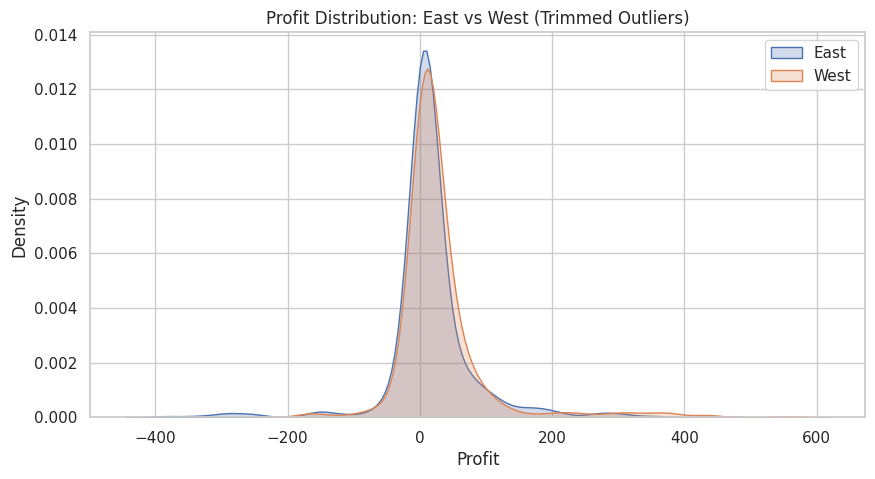

In [ ]:
east_trim = east[east.between(east.quantile(0.01), east.quantile(0.99))]
west_trim = west[west.between(west.quantile(0.01), west.quantile(0.99))]

plt.figure(figsize=(10,5))
sns.kdeplot(east_trim, shade=True, label='East')
sns.kdeplot(west_trim, shade=True, label='West')
plt.title("Profit Distribution: East vs West (Trimmed Outliers)")
plt.xlabel("Profit")
plt.legend()
plt.show()

In [ ]:
t_stat, p_val = stats.ttest_ind(east, west, equal_var=False)
t_stat, p_val


(np.float64(-1.1699895558316595), np.float64(0.24231698321194803))

In [ ]:
diff_mean = east.mean() - west.mean()
n_east, n_west = len(east), len(west)
std_east, std_west = east.std(ddof=1), west.std(ddof=1)

# Standard error
se = np.sqrt((std_east**2/n_east) + (std_west**2/n_west))

# 95% CI
z = 1.96
ci_lower = diff_mean - z * se
ci_upper = diff_mean + z * se

(diff_mean, ci_lower, ci_upper)


(np.float64(-12.652231953062799),
 np.float64(-33.847613146338276),
 np.float64(8.543149240212681))